# Week 4: Interpretable Machine Learning for Data Science

**Problem**: You have been mandated by a large wine-making company in Valais to discover the key chemical factors that determine the quality of wine and build an interpretable model that will help their cellar masters make decisions daily.

## Settings things up (15')

This week will require quite a lot of autonomy on your part, but we will guide you with this high-level notebook. First, take the following steps:

- Install [Poetry](https://python-poetry.org). 
- Then use Poetry to create a virtual environment:

  ```sh
  poetry install
  ```

- Then restart VS Code and add the kernel that corresponds to the environment created by Poetry.

Then, let's set up [black](https://github.com/psf/black), which is a highly encouraged best-practice for all your Python projects. That way, you never have to worry and debate about code formatting anymore. By using it, you agree to cede control over minutiae of hand-formatting. In return, Black gives you speed, determinism, and freedom from `pycodestyle` nagging about formatting. You will save time and mental energy for more important matters.

In [1]:
import jupyter_black

jupyter_black.load()

Here are the libraries you will most likely need and use during this week:

- `numpy` for basic scientific computing and `scipy` for statistical testing.
- `pandas` or `polars` for dataset manipulation. Polars is highly recommended, because it is [awesome](https://github.com/ddotta/awesome-polars). Instructions below will refer to the Polars API.
- `seaborn` for statistical data visualization, but `matplotlib` is always needed anyway. Use both!
- `shap` will be used for [interpretability](https://shap.readthedocs.io/en/stable/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html).
- `sklearn` and `xgboost` will be used for training models. You may import them later when you need them.

In [2]:
# Complete this cell with your code
import numpy as np
import scipy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import shap
import sklearn
import xgboost as xgb

c:\Users\marta\AppData\Local\pypoetry\Cache\virtualenvs\301-explainable-ml-eRtorVWH-py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fetch the data (15')

Here we have a very nice package that can do everything for us (aka `ucimlrepo`). Let's use it!

Take a look at [the website](https://archive.ics.uci.edu/dataset/186/wine+quality) for details.

In [3]:
from ucimlrepo import fetch_ucirepo

# Fetch dataset
wine_repo = fetch_ucirepo(id=186)
df = pd.DataFrame(wine_repo.data.original)

# Display first few rows
print(df.head())

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality color  
0      9.4        5   red  
1      9.8        5   red  
2 

Now, let's check that the data have the correct shape to ensure they have been loaded as expected.

Calculate how many samples and features we have in total, how many are red or white wines, how many are good or bad wines, etc.

In [4]:
# number of sample
df.shape

(6497, 13)

We have 6497 samples and 13 columns in totals. If we remove the two value targets(color and good or bad wine), we have 11 features

In [5]:
# number of white and red wines
print("Red wines", df[df["color"] == "red"].shape[0])
print("White wines", df[df["color"] == "white"].shape[0])

Red wines 1599
White wines 4898


This calculation shows that the number of white wines and red wines makes the dataset unbalanced 

We consider a wine good when his quality is greater than 6

In [6]:
print("Good wines", df[df["quality"] >= 6].shape[0])
print("Bad wines", df[df["quality"] < 6].shape[0])

Good wines 4113
Bad wines 2384


This calculation shows that the number of bad wines and goog wines makes the dataset unbalanced 

## Data Exploration (1h30)

We now will inspect the features one-by-one, and try to understand their dynamics, especially between white and red wines.

- Use `Dataframe.describe` to display statistics on each feature. Do the same for red wines only, and white wines only. Do you notice any clear difference?
- Compute the effect size by computing the [strictly standardized mean difference](https://en.wikipedia.org/wiki/Strictly_standardized_mean_difference) (SSMD) between the red and white wines for each feature. 

In [7]:
# Statistics on features and target value
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [8]:
# Statistics of red wines
df_red = df[df["color"] == "red"]
df_white = df[df["color"] == "white"]
df_red.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [9]:
# Statistics of white wines
df_white.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


We can see that there are features with very different mean values between red wines and white wine like residual_sugar, free_sulfur_dioxide, fixed_acidity.

 ### Compute SSMD between red wines and white wines

In [10]:
ssmd = {}
feature_names = df.columns[:-1]  # Exclude the 'color'
for feature in feature_names:
    # Mean and standard deviation for red and white wines
    mean_red = df_red[feature].mean()
    mean_white = df_white[feature].mean()

    std_red = df_red[feature].std()
    std_white = df_white[feature].std()

    # SSMD calculation
    ssmd_value = (mean_red - mean_white) / ((std_red**2 + std_white**2) ** 0.5)
    ssmd[feature] = ssmd_value

# Display SSMD for each feature
print(
    "\nStrictly Standardized Mean Difference (SSMD) between red and white wines:\n",
    ssmd,
)


Strictly Standardized Mean Difference (SSMD) between red and white wines:
 {'fixed_acidity': 0.7570984913882014, 'volatile_acidity': 1.2146180859422455, 'citric_acid': -0.2756520281549347, 'residual_sugar': -0.7318262377213726, 'chlorides': 0.803525280055768, 'free_sulfur_dioxide': -0.9732927083649252, 'total_sulfur_dioxide': -1.709893545158607, 'density': 0.7689026646492044, 'pH': 0.5688537900809766, 'sulphates': 0.8236123900161837, 'alcohol': -0.056074487578264144, 'quality': -0.20181608588284952}


In this case we can consider that the features volatile_acidity, fixed_acidity,residual_sugar, chlorides, free_sulfur_dioxide, total_sulfur_dioxide, density and sulphates have a significant difference between the two types of wines. We consider a significant difference when it has values greater than 0.5 or <= -0.5

Now let's go a bit deeper into the same analysis, using more visual tools:

- For every feature, plot boxplots, violinplots or histograms for red and white wines. What can you infer? **If you feel a bit more adventurous**, plot the Cumulative Distribution Function (CDF) of the feature for white and red wines, and compute the [Kullback-Leibler divergence](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) (or entropy) between them. Explain why this might be useful.
- Plot the correlation matrix of all features as heatmaps, one for red and one for white wines. How do they differ? What can you infer?

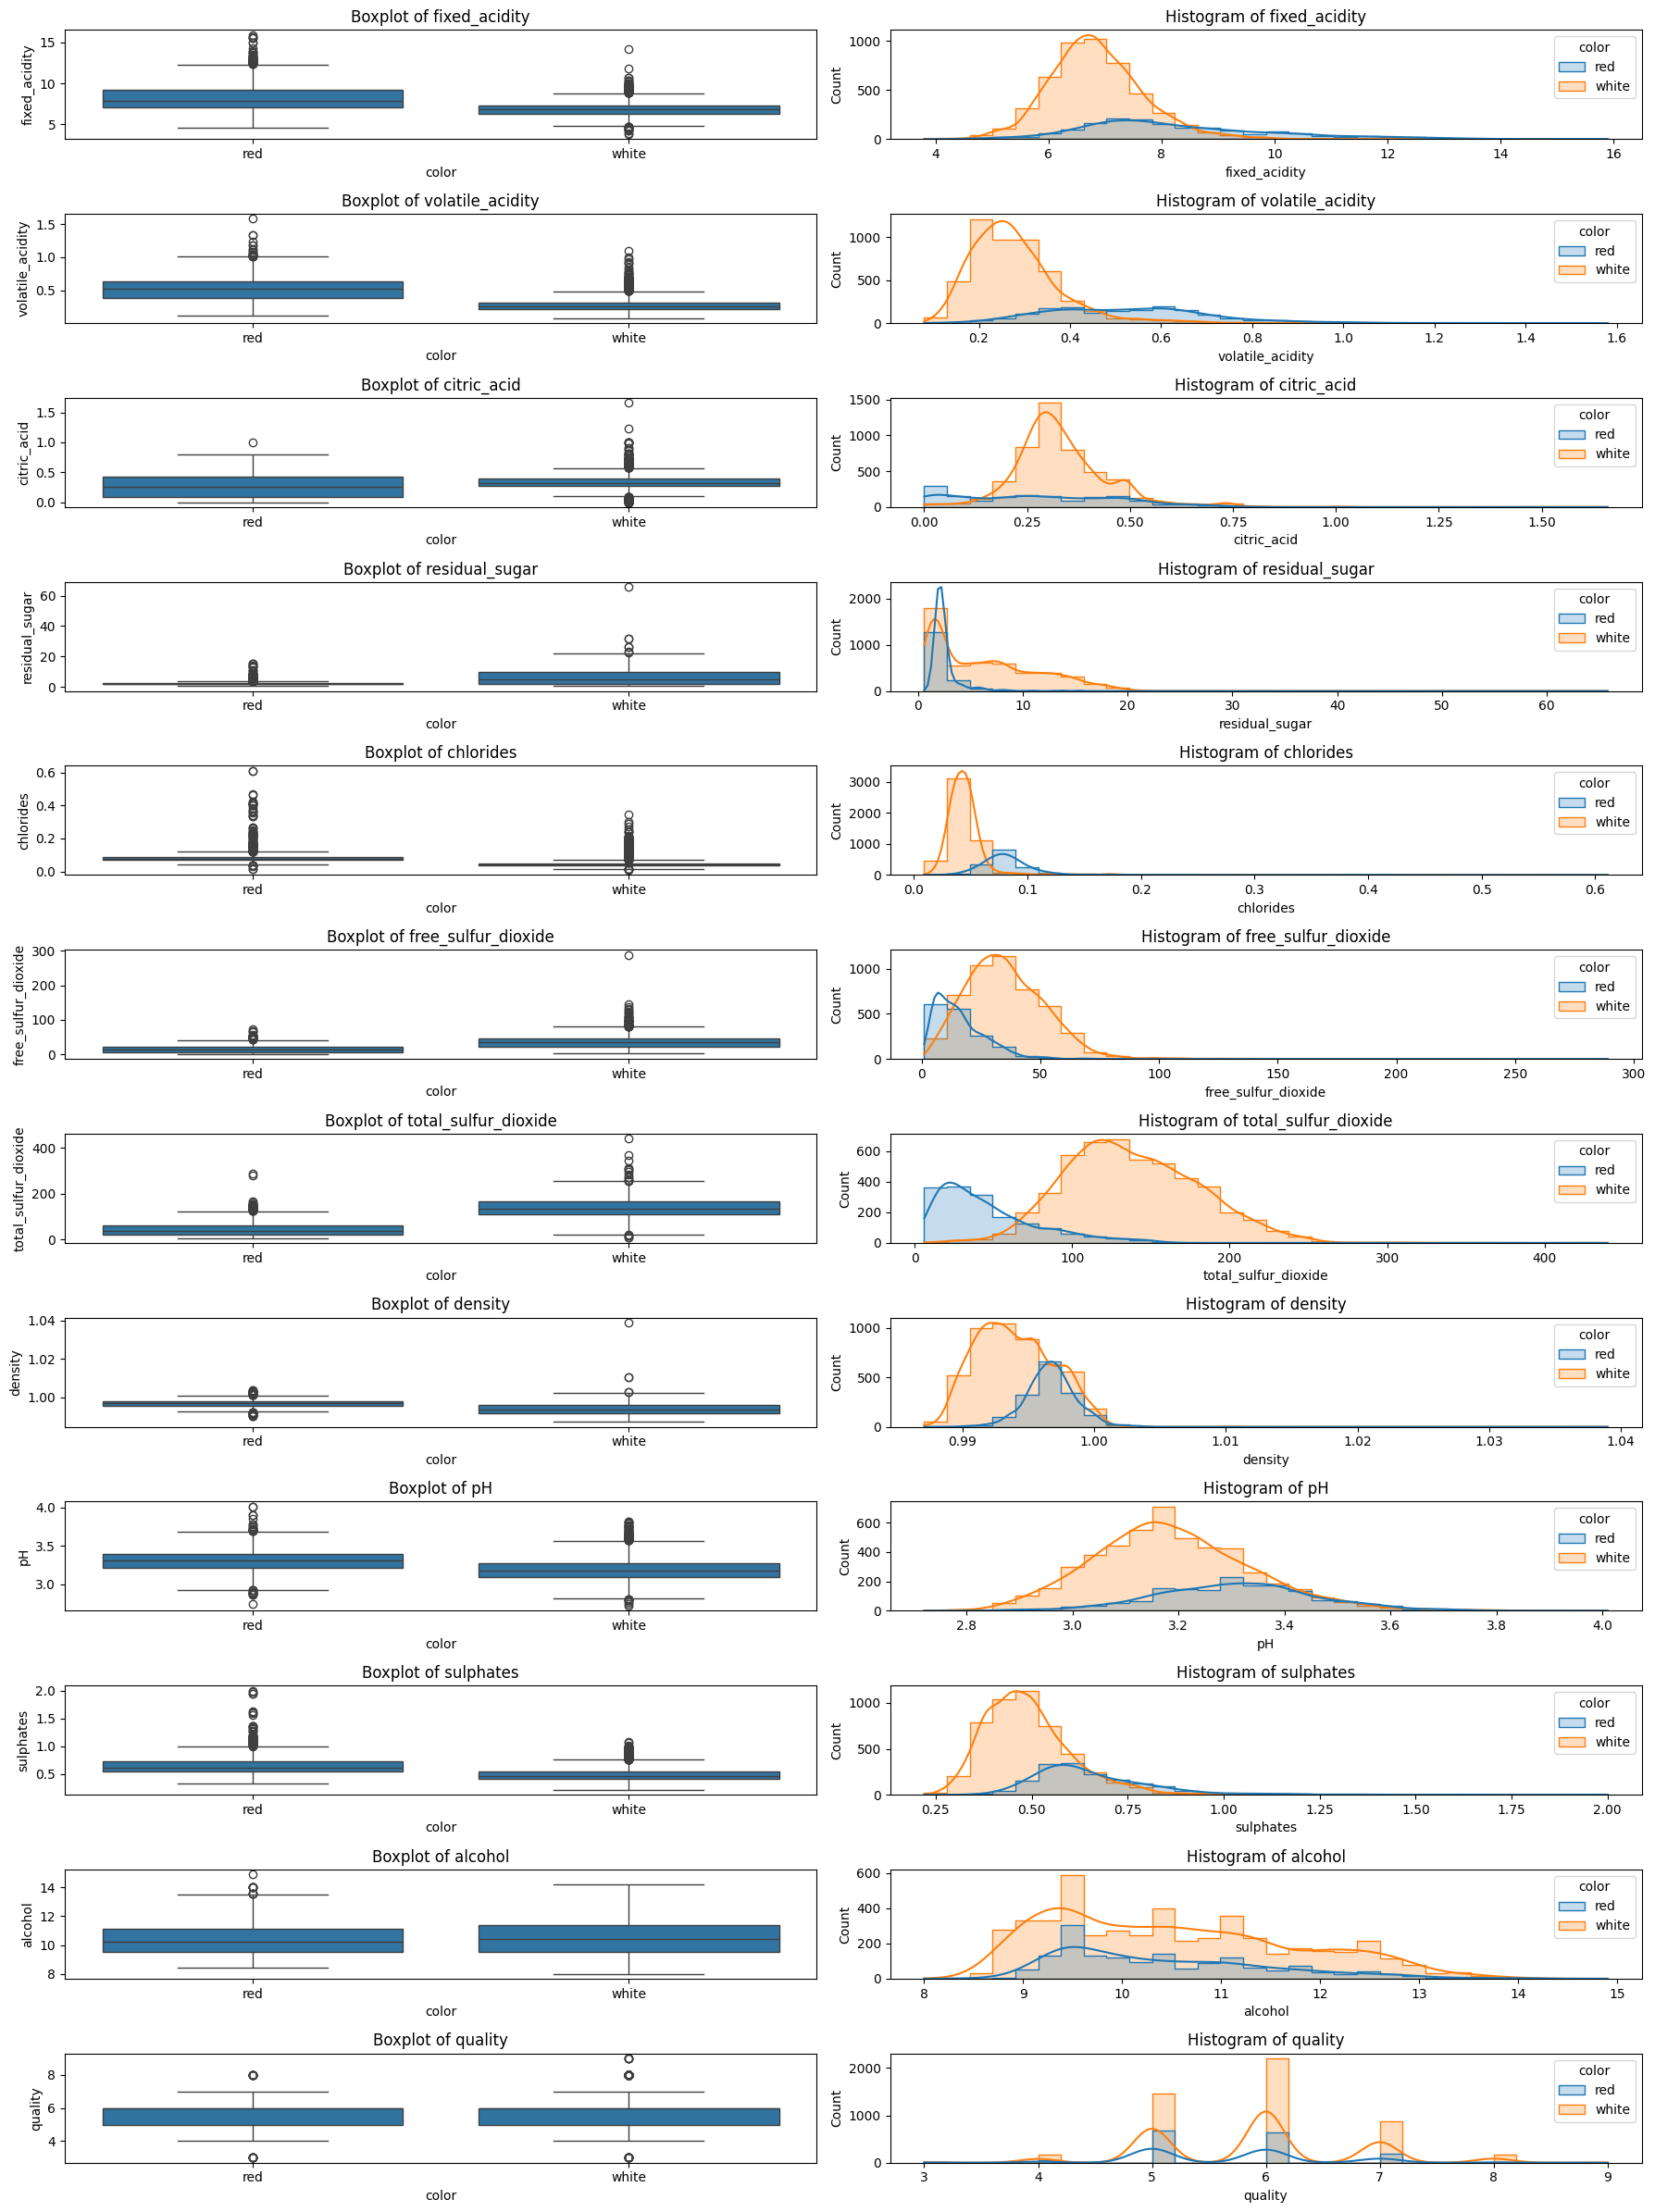

In [11]:
# boxplots, violinplots and histograms
plt.figure(figsize=(18, 24))

for i, feature in enumerate(feature_names):
    plt.subplot(len(feature_names), 2, i * 2 + 1)
    sns.boxplot(x="color", y=feature, data=df)
    plt.title(f"Boxplot of {feature}")

    plt.subplot(len(feature_names), 2, i * 2 + 2)
    sns.histplot(df, x=feature, hue="color", bins=30, kde=True, element="step")
    plt.title(f"Histogram of {feature}")

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

We notice characteristics that differ greatly from red to white wines.
We can see that the median of citric acid is more higher in white wines than in red wines and we can see in histogram that the highest values for red wines are located in 0. For the volatatile acid is the opposite. For the residual sugar we can see, as said before, that white wines contain more than red wines. 
Regarding residual sugar, the median is much lower in red wines, but the histogram distribution does not help us much here.
We can see that the level of alcohol in white and red wines is almost the same. 

### Correlation Matrix 

Text(0.5, 1.0, 'Correlation Matrix for Red Wines')

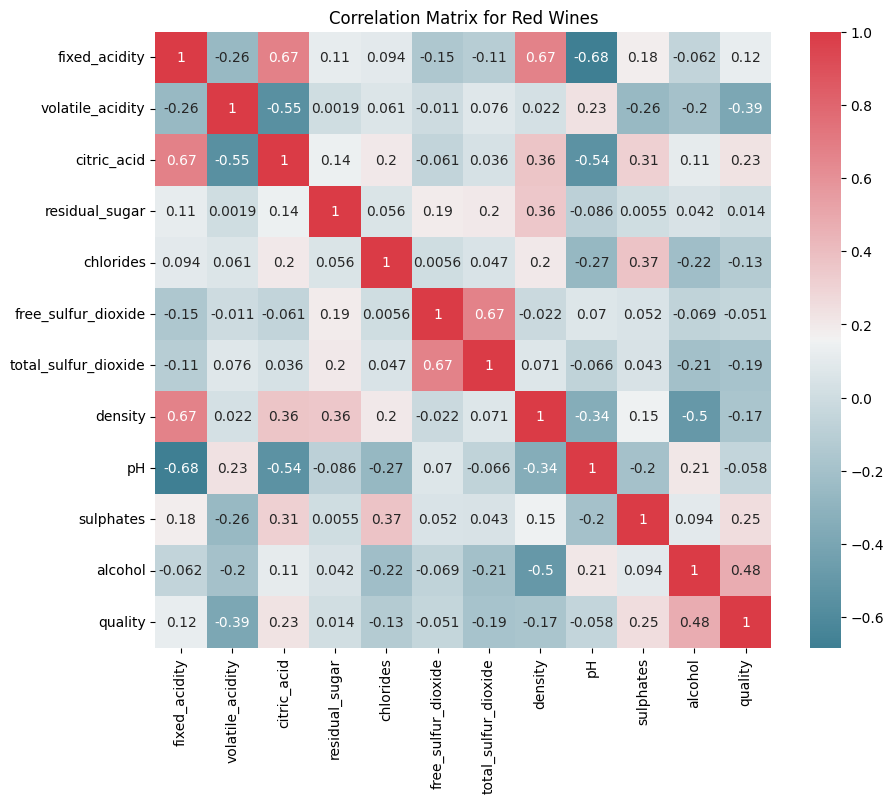

In [12]:
correlation_red = df_red[df.columns[:-1]].corr()
correlation_white = df_white[df.columns[:-1]].corr()
# Plot correlation matrix for red wines

f, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    correlation_red,
    mask=np.zeros_like(correlation_red),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    square=True,
    ax=ax,
    annot=True,
)
plt.title("Correlation Matrix for Red Wines")

Text(0.5, 1.0, 'Correlation Matrix for White Wines')

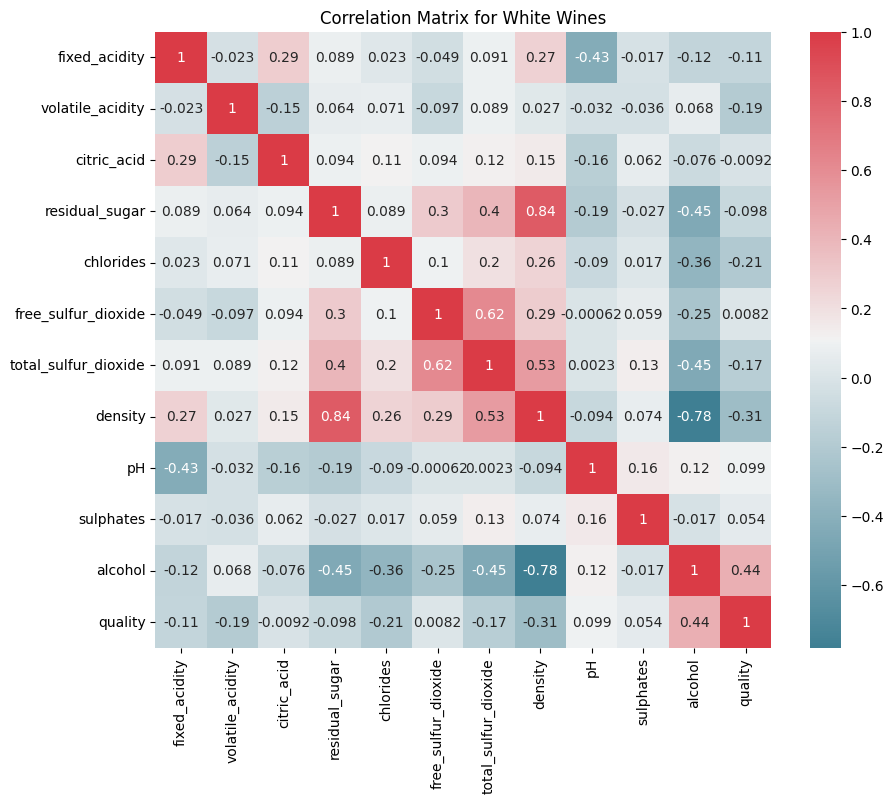

In [13]:
f, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(
    correlation_white,
    mask=np.zeros_like(correlation_white),
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    square=True,
    ax=ax,
    annot=True,
)
plt.title("Correlation Matrix for White Wines")

Differences are noted between the correlations of the characteristics of red wines and white wines. We can see that in white wines, density and residual sugar are more correlated than in red wines. In white wines, there is a greater correlation between density and total sulphur dioxide and between density and free sulphur dioxide. For red wines, there is a greater correlation between fixed acidity and density.

## Data Exploration using Unsupervised Learning (3h)

We first explore the data in an unsupervised fashion. Start by creating a heatmap of the average feature value for red and white wines. Can you spot an easy way to differentiate between reds and whites?

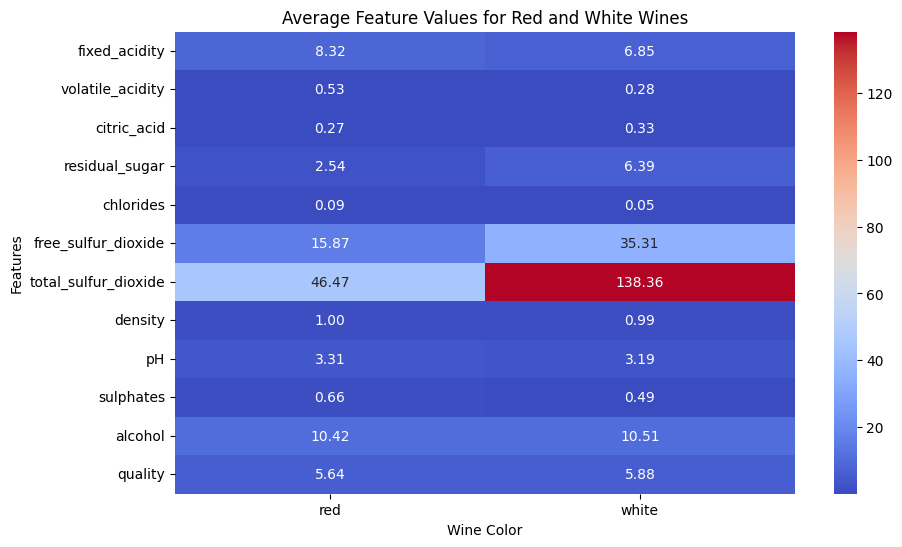

In [14]:
average_features = df.groupby("color").mean().T

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(average_features, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Average Feature Values for Red and White Wines")
plt.xlabel("Wine Color")
plt.ylabel("Features")
plt.show()

To distinguish white wines from red wines, we can look at the average values of some parameters, such as total_sulfur_dioxide, residual sugar and fixed acidity, as these average values are not very close to each other. 

### Using PCA to reduce the dimensionality

Use PCA to reduce the dimensionality of data. Do not forget that it requires data normalization (centering on the mean and scaling to unit variance). Plot the whole dataset onto the two principal components and color it by wine color. What does it tell you?

Project the unit vectors that correspond to each vector onto the principal components, using the same transformation. What does it tell you about the relative feature importance? Does it match the observations you made previously?

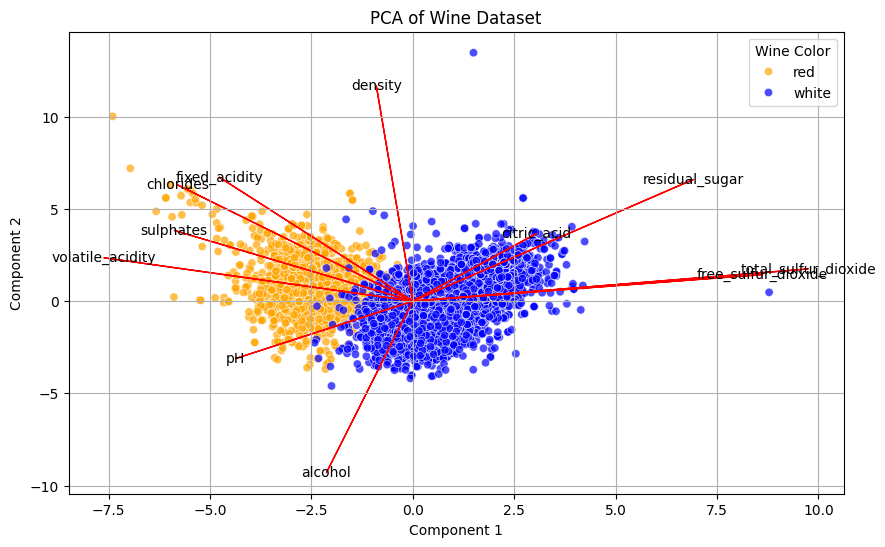

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = df.iloc[:, :-2]
# normalize data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#  PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(features_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_components, columns=["PC1", "PC2"])
pca_df["color"] = df["color"].values
scale_factor = 20
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x="PC1", y="PC2", hue="color", data=pca_df, palette=["orange", "blue"], alpha=0.7
)
for i, feature in enumerate(features):
    plt.arrow(
        0,
        0,
        pca.components_[0, i] * scale_factor,
        pca.components_[1, i] * scale_factor,
        color="r",
        alpha=1.0,
    )

    plt.text(
        pca.components_[0, i] * scale_factor,
        pca.components_[1, i] * scale_factor,
        feature,
        color="black",
        ha="center",
        va="center",
    )

plt.title("PCA of Wine Dataset")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Wine Color")
plt.grid()
plt.show()

We can see that the red wine and white wine can be distinguished quite well with the pca. I've also plotted the different feature vectors to see which are the most important, which influence the most, which are those near to zero on the y-axis. You can see, for example, that alcohol and desity have no effect(near to zero on x-axis).

### Cluster the data in 2-dimensional space

Use k-means to cluster the data into 2 clusters and plot the same view as before, but with a coloring that corresponds to the cluster memberships.

Assuming that the cluster assignments are predictions of a model, what is the performance you can achieve in terms of mutual information score, accuracy, and f1 score?

[[ 0.82763583  1.16722328 -0.33783319 -0.59067186  0.92343436 -0.83180199
  -1.18582946  0.68072127  0.56665448  0.84296711 -0.07620904]
 [-0.28036952 -0.39540801  0.11444421  0.20009572 -0.31282219  0.28178085
   0.40171103 -0.23060082 -0.19195961 -0.28556314  0.02581654]]


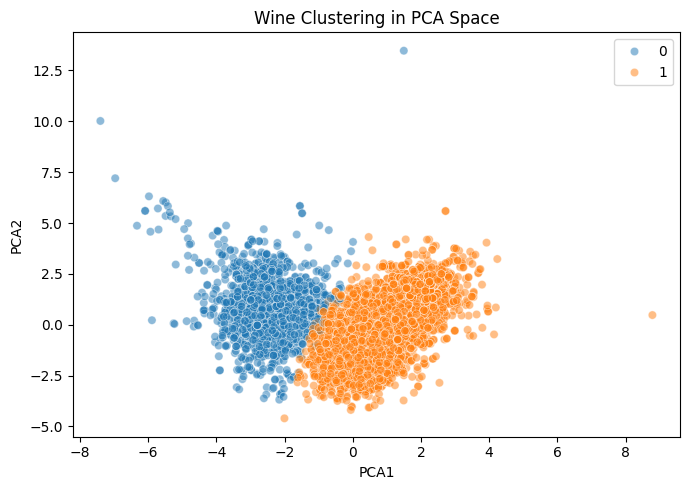

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Apply KMeans clustering to the PCA-transformed data
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

centers = kmeans.cluster_centers_
print(centers)
# Plot the data
plt.figure(figsize=(7, 5))

# Scatter plot of the PCA-transformed data colored by cluster labels
sns.scatterplot(x="PC1", y="PC2", hue=clusters, data=pca_df, alpha=0.5)


plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("Wine Clustering in PCA Space")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

### Metrics 

In [17]:
from sklearn.metrics import accuracy_score, f1_score, mutual_info_score

# we set label as binary value in order to calculate metrics
true_labels = np.where(df["color"] == "red", 0, 1)
predicted_labels = kmeans.labels_
mi_score = mutual_info_score(predicted_labels, true_labels)
accuracy = accuracy_score(predicted_labels, true_labels)
f1 = f1_score(predicted_labels, true_labels)

# Print the performance results
print(f"Mutual Information Score: {mi_score:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

Mutual Information Score: 0.4911
Accuracy: 0.9858
F1 Score: 0.9906


Now, we are going to train a **supervised** linear classification model using `sklearn`, and compare the results with the approach using clustering.

- Set up a train/test dataset using `sklearn.model_selection.train_test_split`.
- Use `GridSearchCV` to perform a cross-validation of the model's regularization `C`.
- Compare the test and train performance at the end. Does the model suffer from any overfitting? 
- Analyze the test performance specifically. What can you conclude about this general problem of recognizing white vs red wines?

In [18]:
# split data
y = df["color"]
y = y.map({"white": 0, "red": 1})
X = df.drop(columns=["color", "quality"])

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mutual_info_score, confusion_matrix

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the model
model = LogisticRegression(max_iter=1000, random_state=42)

# Set up the hyperparameter grid
param_grid = {
    "C": range(1, 100, 1),
}

# Set up Grid Search
grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=5, scoring="accuracy"
)

grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation Score:", grid_search.best_score_)

# Make predictions with the best estimator
y_pred = grid_search.best_estimator_.predict(X_test_scaled)
best_model = grid_search.best_estimator_
# Calculate performance metrics

Best Parameters: {'C': 16}
Best Cross-validation Score: 0.9940353150218406


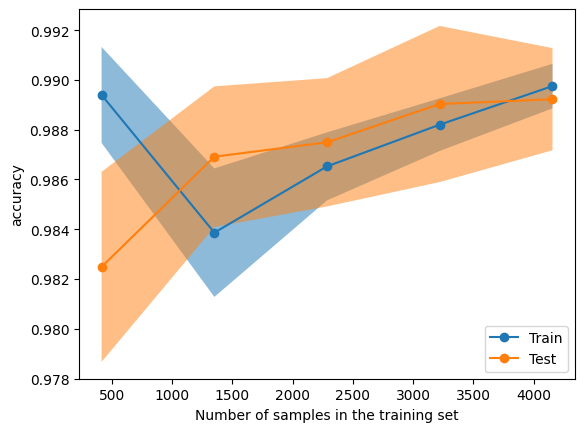

In [21]:
from sklearn.model_selection import LearningCurveDisplay

LearningCurveDisplay.from_estimator(
    best_model,
    X_train,
    y_train,
    scoring="accuracy",
    score_name="accuracy",
    line_kw={"marker": "o"},
    n_jobs=-1,
)

We can see that overfitting is almost absent at some point the test data exceeds that of the train this can be considered acceptable as we are talking about very low percentages, which means that at most one or two samples perform better on the test than on the train

### Basic model interpretability: inspecting the model

As a first step towards intepretability of the model predictions, let's take a look at the coefficients of the model. What is the most important feature from this perspective? How do you interpret positive or negative coefficients?

Is it compatible with what you have seen so far? Do you have an explanation why that might be?

In [22]:
coefficients = best_model.coef_[0]
feature_names = X.columns

coeff_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})

# Sort by the absolute value of the coefficients
coeff_df["Absolute Coefficient"] = coeff_df["Coefficient"].abs()
coeff_df = coeff_df.sort_values(by="Absolute Coefficient", ascending=False)

# Print the sorted coefficients
print(coeff_df)

# Most important feature
most_important_feature = coeff_df.iloc[0]
print(
    f"Most important feature: {most_important_feature['Feature']} with coefficient: {most_important_feature['Coefficient']}"
)

                 Feature  Coefficient  Absolute Coefficient
3         residual_sugar    -4.681032              4.681032
7                density     4.345814              4.345814
6   total_sulfur_dioxide    -3.375380              3.375380
10               alcohol     1.585218              1.585218
1       volatile_acidity     1.434410              1.434410
5    free_sulfur_dioxide     1.366740              1.366740
4              chlorides     0.889867              0.889867
9              sulphates     0.742341              0.742341
2            citric_acid    -0.354934              0.354934
0          fixed_acidity     0.233975              0.233975
8                     pH     0.079103              0.079103
Most important feature: residual_sugar with coefficient: -4.681031543327636


Positive coefficients signal features increase the odds of being classified as red, while negative coefficients indicate features that increase the odds of being classified as white.

### Removing features to test their importance

- What happens if you re-train a model, but remove the most important feature in the list?
- What happens if you re-train the model with a `l1` penalty and you use more regularization? 
- Interpret the results you obtained above from the perspective of the business problem. What does it tell you about the key differences between a red and white wine?

In [23]:
y_without_sugar = df["color"]
y_without_sugar = y_without_sugar.map({"white": 0, "red": 1})
X_without_sugar = df.drop(columns=["color", "quality", "residual_sugar"])

In [24]:
(
    X_train_without_sugar,
    X_test_without_sugar,
    y_train_without_sugar,
    y_test_without_sugar,
) = train_test_split(X_without_sugar, y_without_sugar, test_size=0.2, random_state=42)

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, mutual_info_score


scaler = StandardScaler()
X_train_scaled_without_density = scaler.fit_transform(X_train_without_sugar)
X_test_scaled_without_density = scaler.transform(X_test_without_sugar)
print(X_train_without_sugar)
# Define the model
model_without_sugar = LogisticRegression(
    max_iter=1000, random_state=42, solver="liblinear"
)

# Set up the hyperparameter grid
param_grid = {"C": range(1, 100, 1), "penalty": ["l1"]}

# Set up Grid Search
grid_search_without_sugar = GridSearchCV(
    estimator=model_without_sugar, param_grid=param_grid, cv=5, scoring="accuracy"
)

grid_search_without_sugar.fit(X_train_scaled_without_density, y_train_without_sugar)

# Best parameters and best score
print("Best Parameters:", grid_search_without_sugar.best_params_)
print("Best Cross-validation Score:", grid_search_without_sugar.best_score_)

# Make predictions with the best estimator
y_pred_without_sugar = grid_search_without_sugar.best_estimator_.predict(
    X_test_scaled_without_density
)
best_model_without_sugar = grid_search_without_sugar.best_estimator_
# Calculate performance metrics
accuracy = accuracy_score(y_test_without_sugar, y_pred_without_sugar)
mutual_info = mutual_info_score(y_test_without_sugar, y_pred_without_sugar)

print(f"Accuracy: {accuracy}")
print(f"Mutual Information Score: {mutual_info:.2f}")

      fixed_acidity  volatile_acidity  citric_acid  chlorides  \
1916            6.6             0.240         0.35      0.031   
947             8.3             0.280         0.48      0.093   
877             7.7             0.715         0.01      0.064   
2927            5.2             0.370         0.33      0.028   
6063            6.6             0.260         0.56      0.053   
...             ...               ...          ...        ...   
3772            7.6             0.320         0.58      0.050   
5191            5.6             0.280         0.27      0.043   
5226            6.4             0.370         0.20      0.117   
5390            6.5             0.260         0.50      0.051   
860             7.2             0.620         0.06      0.077   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
1916                 36.0                 135.0  0.99380  3.19       0.37   
947                   6.0                  12.0  0.99408  3.26   

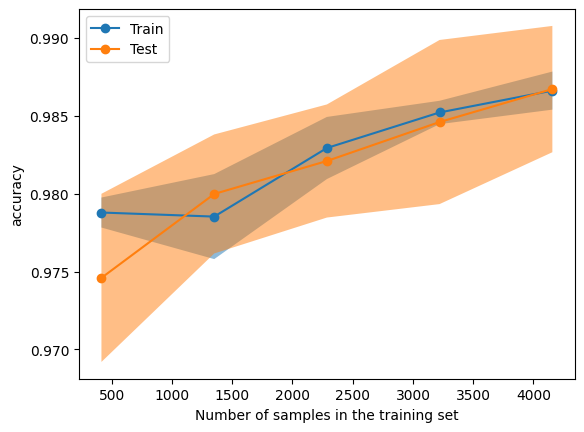

In [26]:
LearningCurveDisplay.from_estimator(
    best_model_without_sugar,
    X_train,
    y_train,
    scoring="accuracy",
    score_name="accuracy",
    line_kw={"marker": "o"},
    n_jobs=-1,
)

Performances are not impacted this may be due to the fact that the features are highly correlated with each other. Overfitting also remains almost zero. Even using the l1 penalty to train the model does not change the final results of the model

### Using Shapley values

Now, use SHAP to explore how the model perceives a 'red' and 'white' wine.

- Use a `beeswarm` plot to analyze the influence of each feature on the model's output.
- What does the plot tell us about what makes a white wine 'white' and a red wine 'red'?

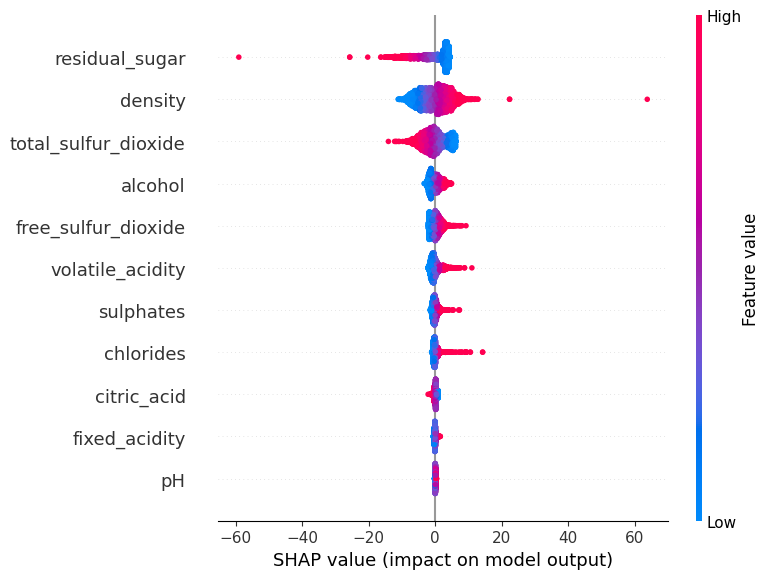

In [27]:
explainer = shap.LinearExplainer(best_model, X_train_scaled)

# Calculate SHAP values for the training data
shap_values = explainer.shap_values(X_train_scaled)
shap.summary_plot(shap_values, X_train_scaled, feature_names=X.columns)

We can see that the most important features are residual_sugar and density. Given that we have assigned 0 to the white wine class and 1 to the red wine class, we can say that all negative SHAP values tend to predict white and all positive values tend to predict red. 
We can see, that with very high sugar values we will have a white wine(see the features values color). As far as density is concerned we have the opposite effect, the more we have lower density values more our model will try to predict white.

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.

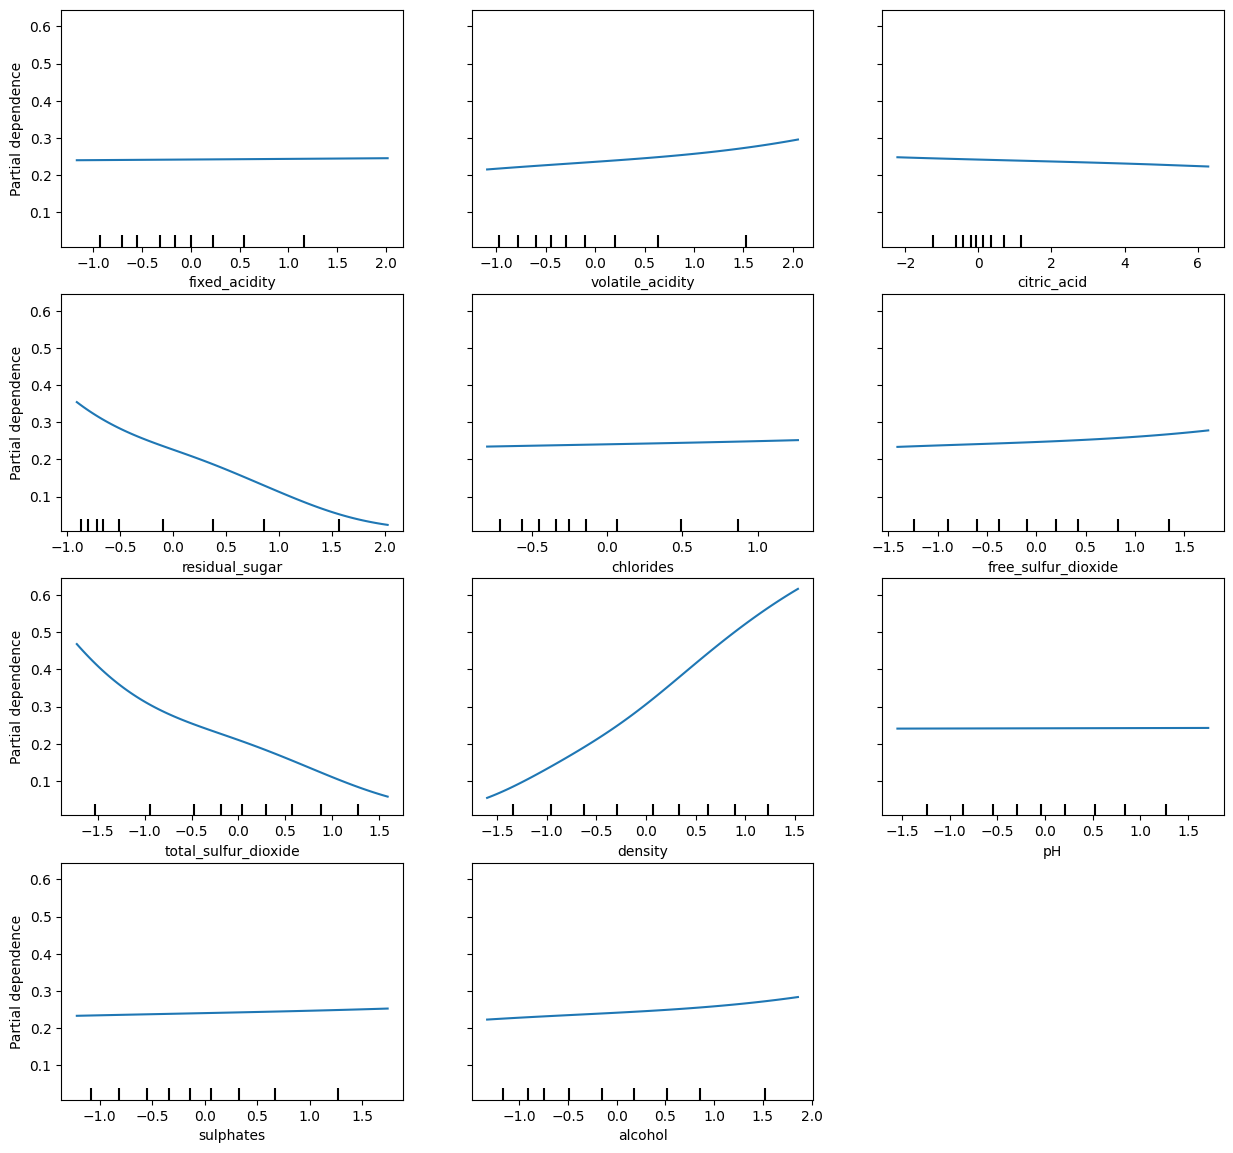

In [28]:
from sklearn.inspection import PartialDependenceDisplay

features_of_interest = X.columns
fig, ax = plt.subplots(figsize=(15, 10))
display = PartialDependenceDisplay.from_estimator(
    grid_search.best_estimator_,
    X_train_scaled,
    features=features_of_interest,
    ax=ax,
    feature_names=features_of_interest,
)


plt.subplots_adjust(top=1.2)
plt.show()

In these graphs, we can see how much variation in the value of a feature can change our predictions. We can see that features with flat lines have low influence.  We can see that the influent ones create curves and correspond to the most important features of the beeswarm graph

- Now use a waterfall diagram on a specific red and white wine and see how the model has made this specific prediction. 

### For red wine

1


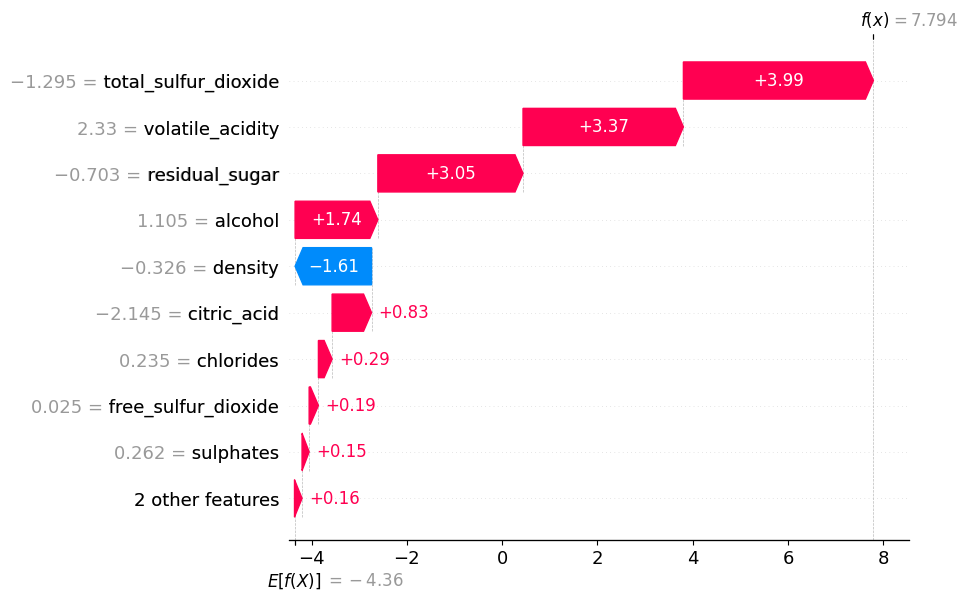

In [29]:
X_train_scaled_df = pd.DataFrame(
    X_train_scaled, columns=X.columns
)  # for the names of features

# Calculate SHAP values using the trained model
explainer = shap.Explainer(grid_search.best_estimator_, X_train_scaled_df)
shap_values = explainer(X_train_scaled_df)

# Choose an instance index (for example, the first instance)
instance_index = 2  # Change this index to select a different instance

# Get SHAP values for the specific instance
instance_shap_values = shap_values[instance_index]

# Retrieve the target value (e.g., y_train) for the instance
target_value = y_train.iloc[instance_index]  # Assuming y_train is a DataFrame or Series
print(target_value)
# Create the waterfall plot
shap.plots.waterfall(instance_shap_values)

### For white wine

0


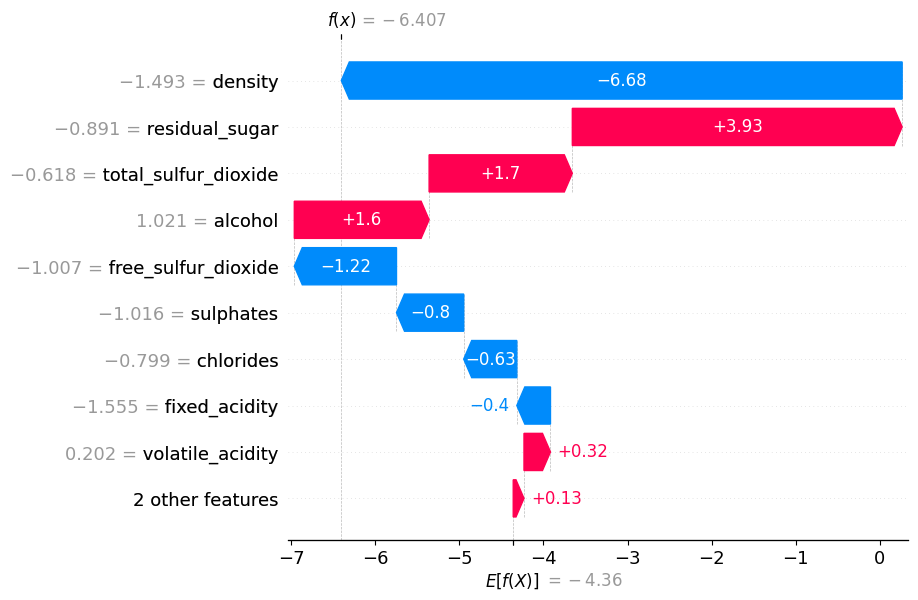

In [30]:
X_train_scaled_df = pd.DataFrame(
    X_train_scaled, columns=X.columns
)  # for the names of features

# Calculate SHAP values using the trained model
explainer = shap.Explainer(grid_search.best_estimator_, X_train_scaled_df)
shap_values = explainer(X_train_scaled_df)

# Choose an instance index (for example, the first instance)
instance_index = 3

# Get SHAP values for the specific instance
instance_shap_values = shap_values[instance_index]

# Retrieve the target value (e.g., y_train) for the instance
target_value = y_train.iloc[instance_index]  # Assuming y_train is a DataFrame or Series
print(target_value)
# Create the waterfall plot
shap.plots.waterfall(instance_shap_values)

We can see that for red wine we have a positive value prediction whereas for white wine a negative value prediction.
We can see that the most impacting features for white wines are density, residual sugar and total sulphur dioxide, while for red wines we have total sulphur dioxide, alchol and residual sugar.

- Now, let's take an example where the model has made an incorrect prediction, and see how it made this prediction.

In [31]:
# find incorrect prediction
incorrect_predictions = [
    (i, y_pred[i], y_test.iloc[i])
    for i in range(len(y_test))
    if y_pred[i] != y_test.iloc[i]
]
print(incorrect_predictions)

[(103, 1, 0), (178, 0, 1), (207, 1, 0), (209, 1, 0), (317, 0, 1), (346, 1, 0), (550, 0, 1), (796, 0, 1), (807, 0, 1), (831, 1, 0), (969, 0, 1), (1072, 0, 1), (1178, 0, 1)]


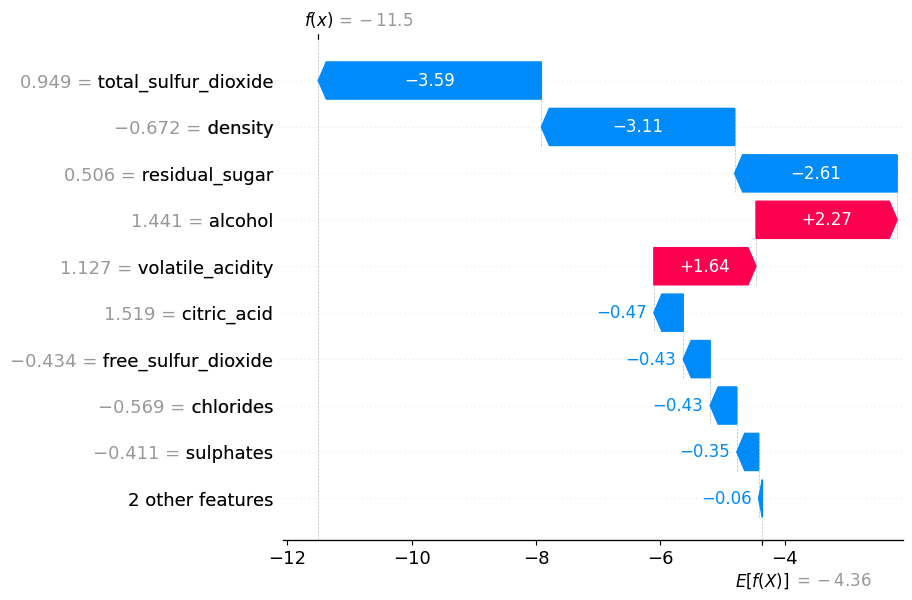

Actual Value: 1, Predicted Value: 0


In [32]:
instance_index = incorrect_predictions[0][0]
specific_instance = X.iloc[instance_index]

# Get the actual value (ground truth) for the specific instance
actual_value = y.iloc[instance_index]

# Step 2: Calculate SHAP values using the trained model
explainer = shap.Explainer(grid_search.best_estimator_, X_train_scaled)
shap_values = explainer(X_train_scaled_df)

# Get SHAP values for the specific instance
instance_shap_values = shap_values[instance_index]

# Step 3: Create the waterfall plot
shap.plots.waterfall(instance_shap_values)

# Print the actual and predicted values for context
predicted_value = grid_search.best_estimator_.predict(
    specific_instance.values.reshape(1, -1)
)
print(f"Actual Value: {actual_value}, Predicted Value: {predicted_value[0]}")

The wine was supposed to be red but was classified as white 

# Good vs Bad classification (3h)

We are going to work on a binary classification problem, where all wines with a quality higher than 6 are considered as "good" and other are considered as "bad".  

- Prepare a dataset with a new column `binary_quality` that corresponds to the above definition.

In [33]:
df["binary_quality"] = np.where(df["quality"] >= 6, 1, 0)

One question that we might ask right away is:

- Is there any correlation of the quality and the color of the wine? 



Ideally, there should be almost none. Why could it be a problem otherwise?

If it turns out that there are significantly more bad red wines than bad white wines or vice versa, what are the implications for your analysis?

- Plot a heatmap of the mean feature value for bad and good wines, like we did before for red and white wines.
- Plot two heatmaps, one for red and white wines. How do they differ? What kind of issue can it cause?

In [34]:
df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color,binary_quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white,1
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white,1
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white,1


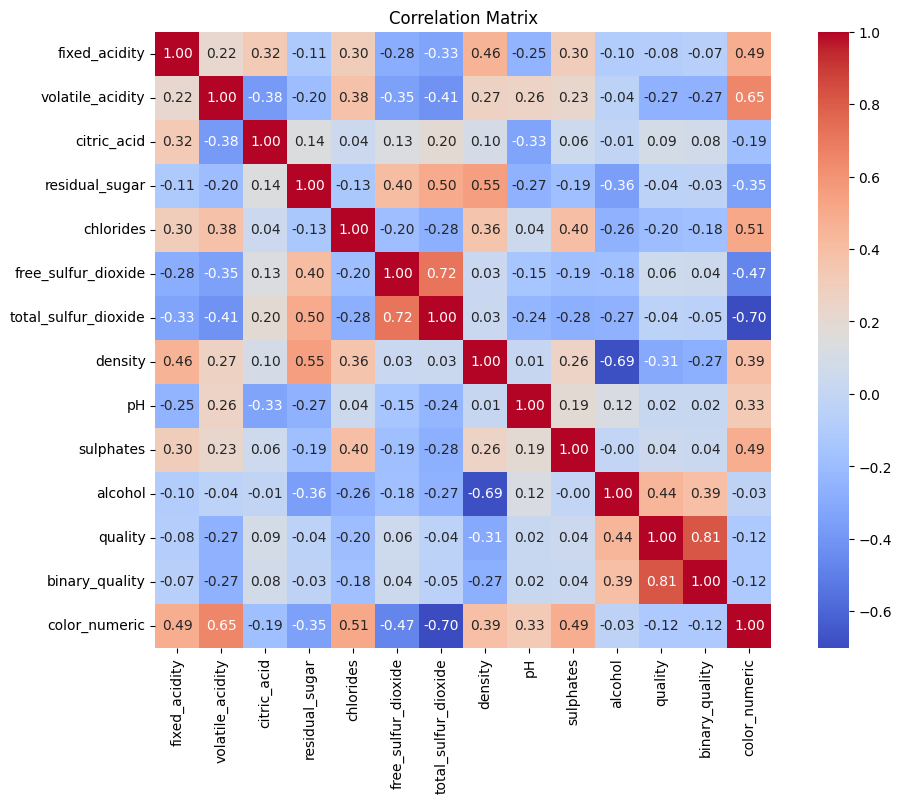

In [35]:
df["color_numeric"] = df["color"].map({"red": 1, "white": 0})

correlation_matrix = df.drop(columns=["color"]).corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

We can see that the correlation between quality and colo is close to zero so they are independent of each other. A potential correlation could have led to wrong predictions if we decided to use colour to predict if a wine is good or not

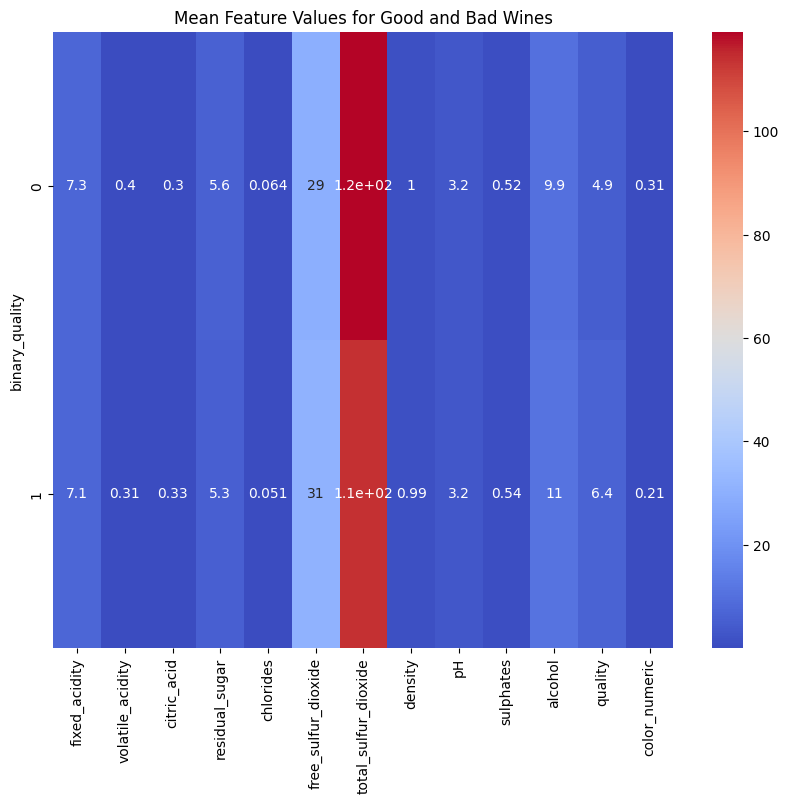

In [36]:
mean_features = df.groupby("binary_quality").mean(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(mean_features, annot=True, cmap="coolwarm")
plt.title("Mean Feature Values for Good and Bad Wines")
plt.show()

We can see that, unlike before, the average of the features for distinguishing good from bad are almost the same, which makes it difficult to know which feature can help us the most in knowing when a wine is good and when it is bad.

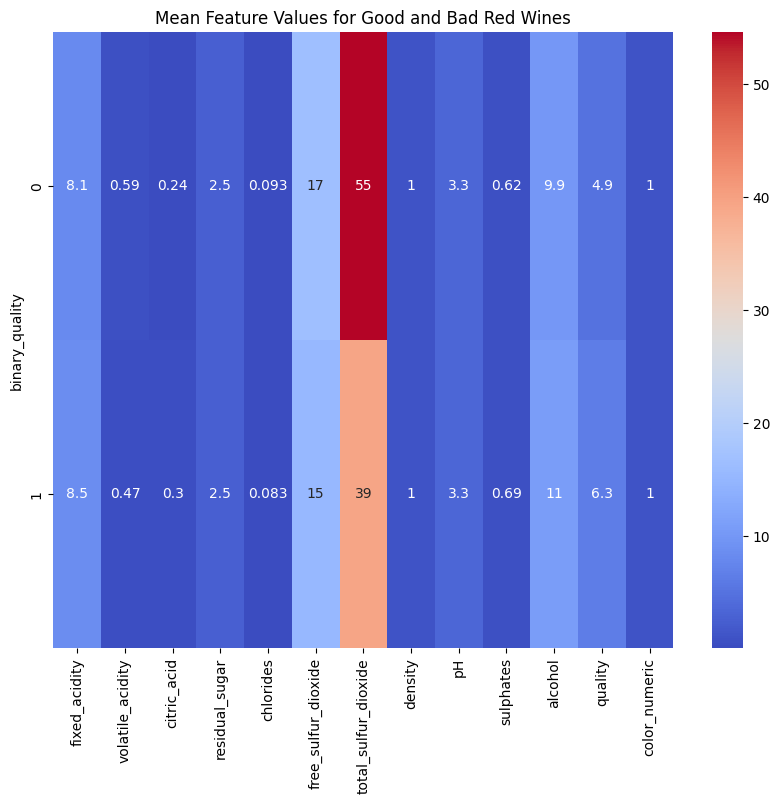

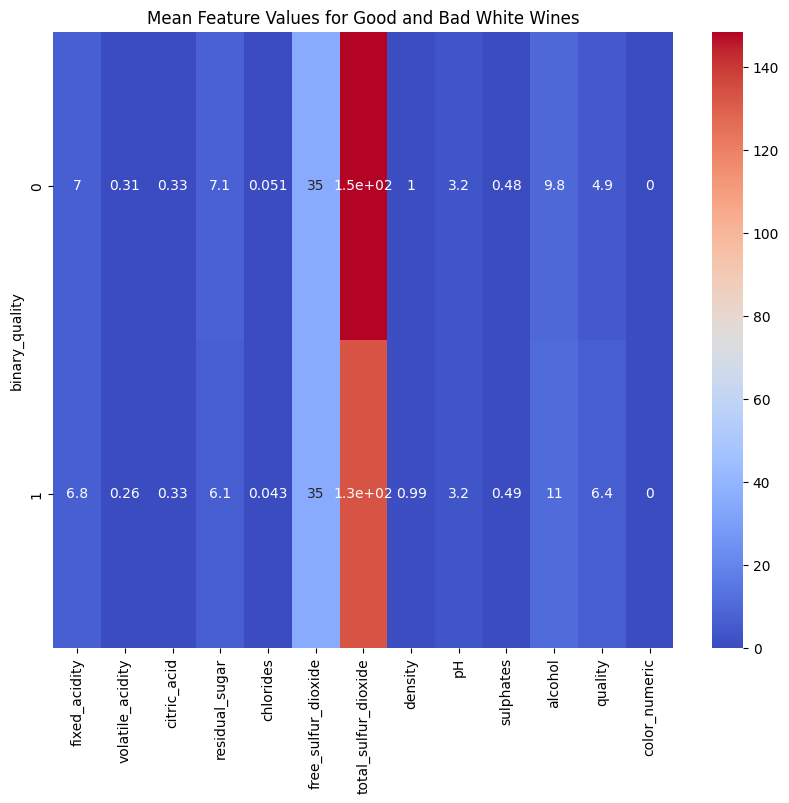

In [37]:
# Calculate the mean feature values for red wines
df_red = df[df["color"] == "red"]
df_white = df[df["color"] == "white"]
mean_features_red = df_red.groupby(["binary_quality"]).mean(numeric_only=True)

# Calculate the mean feature values for white wines
mean_features_white = df_white.groupby(["binary_quality"]).mean(numeric_only=True)

# Plot heatmap for red wines
plt.figure(figsize=(10, 8))
sns.heatmap(mean_features_red, annot=True, cmap="coolwarm")
plt.title("Mean Feature Values for Good and Bad Red Wines")
plt.show()

# Plot heatmap for white wines
plt.figure(figsize=(10, 8))
sns.heatmap(mean_features_white, annot=True, cmap="coolwarm")
plt.title("Mean Feature Values for Good and Bad White Wines")
plt.show()

If we split wines into reds or whites, we have a feature that, depending on if the wine is good or not, gives quite different average values, i.e. total_sulfur_dioxide, so we have a better situation than before but no better than the model that classified if a wine was white or red.

It is a lot more difficult now to tell apart good from bad wines. Let's turn to a more complex model, which is a [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) [Trees](https://xgboost.readthedocs.io/en/stable/tutorials/model.html). For the sake of interpretability, design your notebook so that you can easily filter on only white and red wines and perform again the entire procedure.

Let's first train a XGBClassifier model to distinguish between good and bad wines. Make sure to use the same best-practices (train/test split, cross-validation) as we did before. Note that the regularization of the GBTs is a lot more complex than for Logistic Regression. Test the following parameters:

  ```py
  param_grid = {
    "max_depth": [3, 4, 5],  # Focus on shallow trees to reduce complexity
    "learning_rate": [0.01, 0.05, 0.1],  # Slower learning rates
    "n_estimators": [50, 100],  # More trees but keep it reasonable
    "min_child_weight": [1, 3],  # Regularization to control split thresholds
    "subsample": [0.7, 0.9],  # Sampling rate for boosting
    "colsample_bytree": [0.7, 1.0],  # Sampling rate for columns
    "gamma": [0, 0.1],  # Regularization to penalize complex trees
  }
  ```

In [38]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt


# Step 2: Train-Test Split
def train_test_split_data(df):
    X = df.drop(columns=["quality", "binary_quality", "color"])
    y = df["binary_quality"]
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Step 3: Model Training and Hyperparameter Tuning
def train_xgb_classifier(X_train, y_train):
    param_grid = {
        "max_depth": [3, 4, 5],
        "learning_rate": [0.01, 0.05, 0.1],
        "n_estimators": [50, 100],
        "min_child_weight": [1, 3],
        "subsample": [0.7, 0.9],
        "colsample_bytree": [0.7, 1.0],
        "gamma": [0, 0.1],
    }

    xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring="accuracy",
        cv=3,
        verbose=1,
        n_jobs=-1,
    )
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    return grid_search.best_estimator_


# Step 4: Evaluate Model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")


# For red wines
red_wine_data = df[df["color"] == "red"]
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split_data(red_wine_data)
model_red = train_xgb_classifier(X_train_red, y_train_red)
evaluate_model(model_red, X_test_red, y_test_red)

# For white wines
white_wine_data = df[df["color"] == "white"]
X_train_white, X_test_white, y_train_white, y_test_white = train_test_split_data(
    white_wine_data
)
model_white = train_xgb_classifier(X_train_white, y_train_white)
evaluate_model(model_white, X_test_white, y_test_white)

# for all wines
X_train, X_test, y_train, y_test = train_test_split_data(df)
model = train_xgb_classifier(X_train, y_train)
evaluate_model(model, X_test, y_test)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


c:\Users\marta\AppData\Local\pypoetry\Cache\virtualenvs\301-explainable-ml-eRtorVWH-py3.11\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 50, 'subsample': 0.9}
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.83      0.79       149
           1       0.84      0.75      0.79       171

    accuracy                           0.79       320
   macro avg       0.79      0.79      0.79       320
weighted avg       0.80      0.79      0.79       320

Confusion Matrix:
 [[124  25]
 [ 42 129]]
Accuracy: 0.79
Fitting 3 folds for each of 288 candidates, totalling 864 fits


c:\Users\marta\AppData\Local\pypoetry\Cache\virtualenvs\301-explainable-ml-eRtorVWH-py3.11\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\marta\AppData\Local\pypoetry\Cache\virtualenvs\301-explainable-ml-eRtorVWH-py3.11\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.67      0.69       328
           1       0.84      0.87      0.85       652

    accuracy                           0.80       980
   macro avg       0.78      0.77      0.77       980
weighted avg       0.80      0.80      0.80       980

Confusion Matrix:
 [[219 109]
 [ 88 564]]
Accuracy: 0.80
Fitting 3 folds for each of 288 candidates, totalling 864 fits
Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.68      0.71       477
           1       0.82      0.86      0.84       823

    accuracy                   

c:\Users\marta\AppData\Local\pypoetry\Cache\virtualenvs\301-explainable-ml-eRtorVWH-py3.11\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


- Analyze the results (test and train), validate whether there is overfitting.

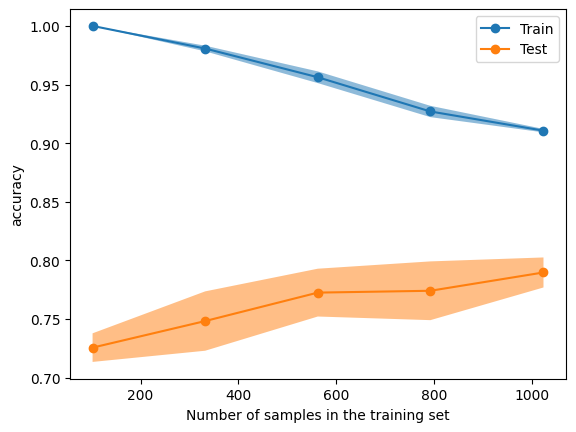

In [39]:
LearningCurveDisplay.from_estimator(
    model_red,
    X_train_red,
    y_train_red,
    scoring="accuracy",
    score_name="accuracy",
    line_kw={"marker": "o"},
    n_jobs=-1,
)

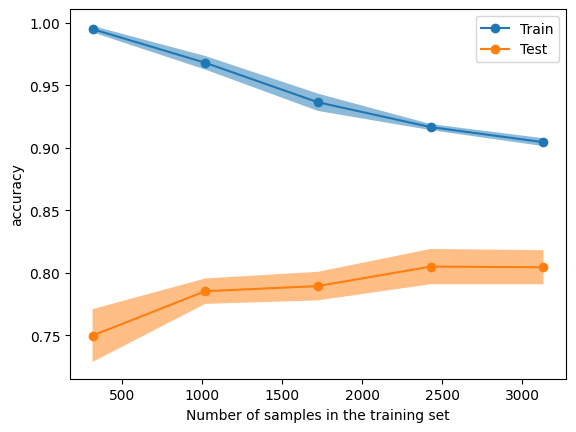

In [40]:
LearningCurveDisplay.from_estimator(
    model_white,
    X_train_white,
    y_train_white,
    scoring="accuracy",
    score_name="accuracy",
    line_kw={"marker": "o"},
    n_jobs=-1,
)

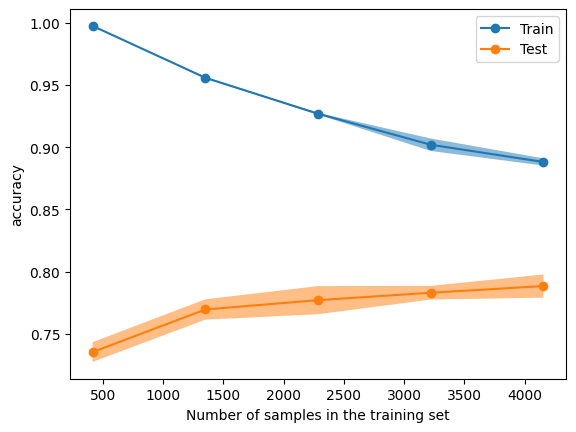

In [41]:
LearningCurveDisplay.from_estimator(
    model,
    X_train,
    y_train,
    scoring="accuracy",
    score_name="accuracy",
    line_kw={"marker": "o"},
    n_jobs=-1,
)

We have more overfitting than the model used before with logistic regression, but we can consider the gap to be acceptable. Accuracy is less good compared to the classification of red wine and white wine, but remains high (about 80%)

## Interpretability with SHAP (2h)

- Plot the feature importance (gain and cover) from the XGBoost model. What can you conclude?

In [42]:
importance = model.feature_importances_
importance

array([0.05332316, 0.14133462, 0.05655413, 0.05892187, 0.05391039,
       0.06752038, 0.06243766, 0.05835715, 0.05278447, 0.06616494,
       0.2345923 , 0.09409885], dtype=float32)

In [43]:
df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color,binary_quality,color_numeric
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red,0,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red,0,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red,1,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white,1,0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white,0,0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white,1,0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white,1,0


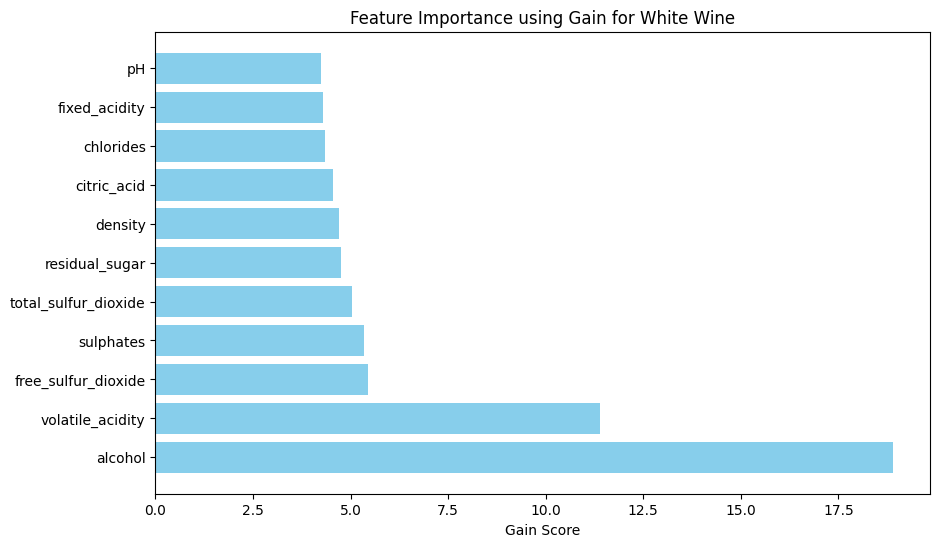

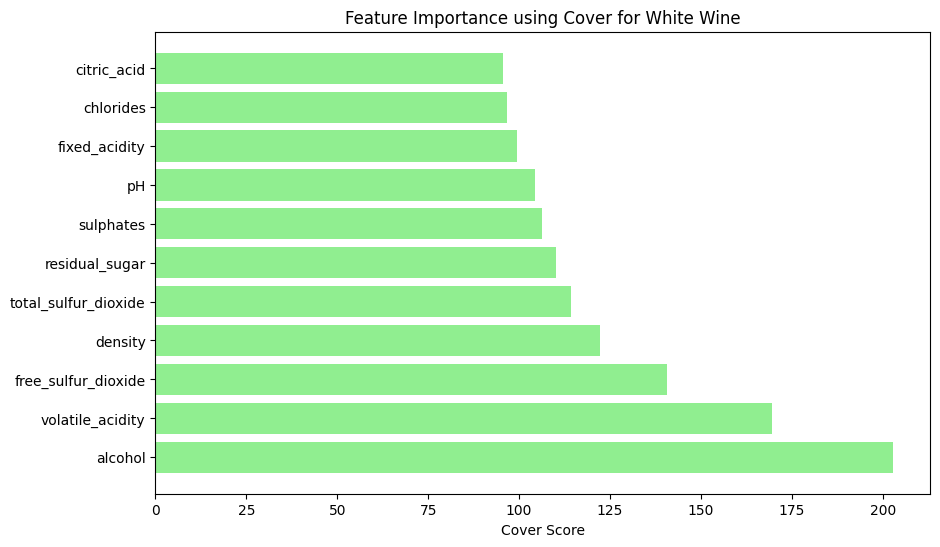

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import shap

wines_white = X_train[X_train["color_numeric"] == 0]
# wines_white = wines_white.drop(columns=["color_numeric"])

# Get the booster model from the trained model
booster = model.get_booster()

# Calculate importance scores using Gain and Cover
importance_gain = booster.get_score(importance_type="gain")
importance_cover = booster.get_score(importance_type="cover")


# Convert to DataFrame for better visualization
importance_gain_df = pd.DataFrame(importance_gain.items(), columns=["Feature", "Gain"])
importance_cover_df = pd.DataFrame(
    importance_cover.items(), columns=["Feature", "Cover"]
)
importance_gain_df = importance_gain_df[
    importance_gain_df["Feature"] != "color_numeric"
]
importance_cover_df = importance_cover_df[
    importance_cover_df["Feature"] != "color_numeric"
]
# Plot Gain
plt.figure(figsize=(10, 6))
importance_gain_df = importance_gain_df.sort_values(by="Gain", ascending=False)
plt.barh(importance_gain_df["Feature"], importance_gain_df["Gain"], color="skyblue")
plt.title("Feature Importance using Gain for White Wine")
plt.xlabel("Gain Score")
plt.show()

# Plot Cover
plt.figure(figsize=(10, 6))
importance_cover_df = importance_cover_df.sort_values(by="Cover", ascending=False)
plt.barh(
    importance_cover_df["Feature"], importance_cover_df["Cover"], color="lightgreen"
)
plt.title("Feature Importance using Cover for White Wine")
plt.xlabel("Cover Score")
plt.show()

we can deduce that the most important features are alcohol, volatile acidity, density and total sulphur dioxide.

- Use SHAP's `TreeExplainer` to compute feature importance (Shapley values). Do you see any difference with XGBoost's feature importances?
- Produce different plots to analyze Shapley values: 
  - A bar plot that summarizes the mean absolute value of each feature.
  - A beeswarm plot that shows the shapley value for every sample and every feature.
  - A [heatmap plot](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) that indicates how different feature patterns influence the model's output.
- Based on the above results, what makes a wine 'good' or 'bad'?

In [60]:
explainer = shap.Explainer(model)

shap_values = explainer(wines_white)

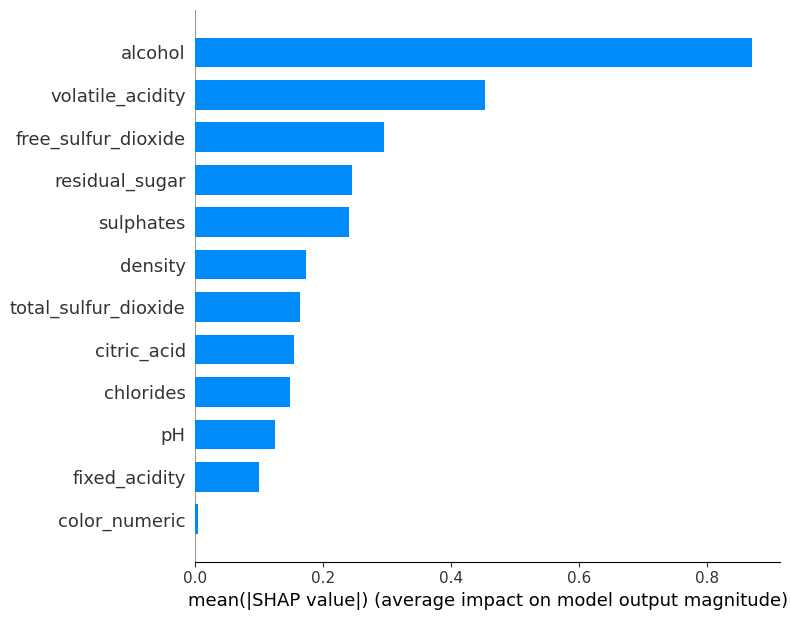

In [61]:
shap.summary_plot(shap_values, wines_white, plot_type="bar")

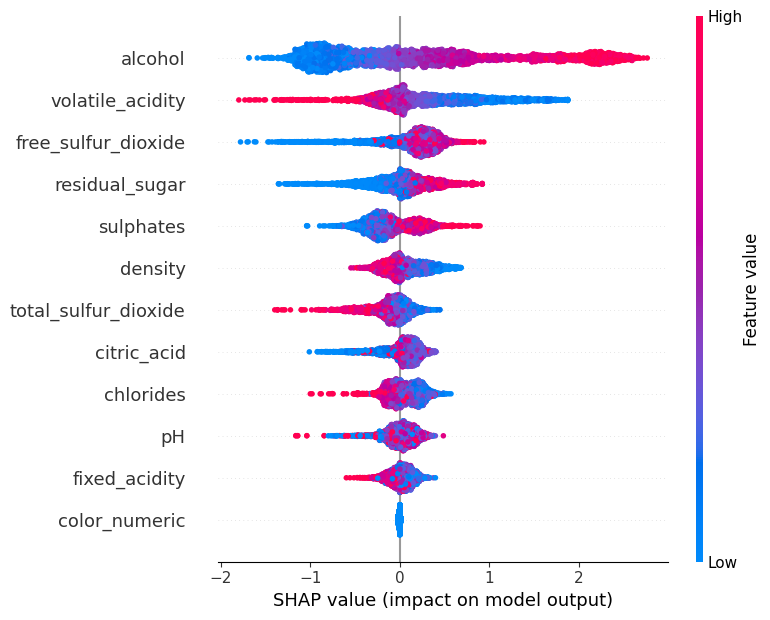

In [62]:
shap.summary_plot(shap_values, wines_white)

we can see that for high alcohol values we have better good wines and for low volatile_acidity values we have better wines 

In [63]:
import shap

explainer = shap.Explainer(model, X)

shap_values = explainer(wines_white[:1000], check_additivity=False)


shap_values_train = explainer(wines_white, check_additivity=False)

 94%|=================== | 3651/3892 [00:13<00:00]       

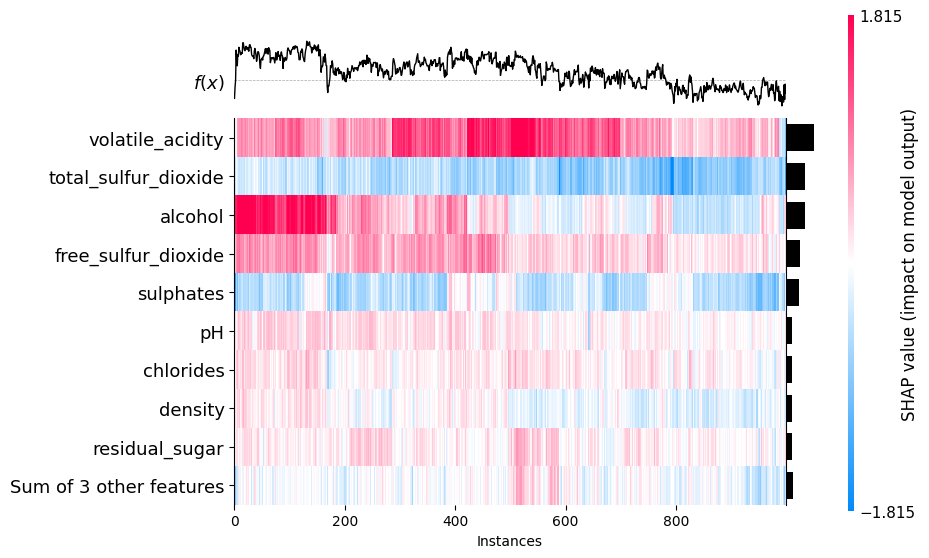

<Axes: xlabel='Instances'>

In [49]:
shap.plots.heatmap(shap_values)

- Now use Partial Dependence Plots to see how the expected model output varies with the variation of each feature.
- How does that modify your perspective on what makes a good or bad wine?

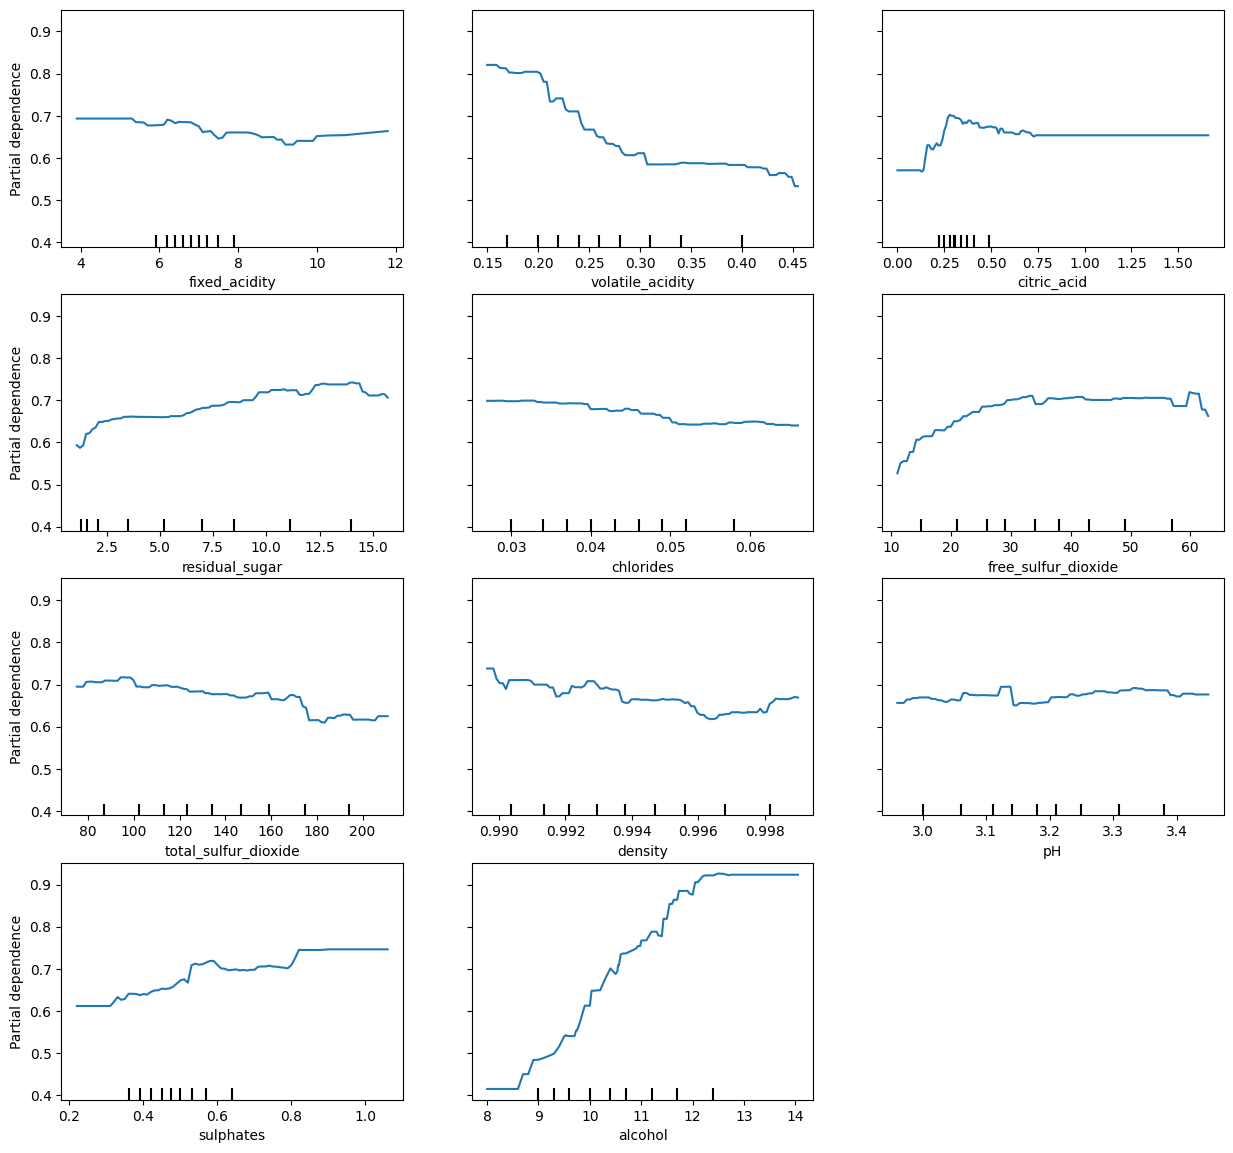

In [64]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features = list(range(X_train.shape[1] - 1))
fig, ax = plt.subplots(figsize=(15, 10))
PartialDependenceDisplay.from_estimator(model, wines_white, features, ax=ax)

plt.subplots_adjust(top=1.2)
plt.show()

We can see the same correspondence as with red and white wines so those with more impact have non-flat curves and those with less impact have flat curves. The importance of the featues corresponds to the graph above (beeswarm). For example for alcohol, the higher the value, the more likely we have a good wine 

- Search for literature or resources that provide indications of the chemical structure of good or poor wines. Do your findings match these resources? 

Looking for the main characteristics of wine that change its flavour we have sweetness, acidity and alcohol level. We can see that in our analysis the alcohol level and acidity strongly influence the quality of the wine. We can see on partial dependencies that these three characteristics have quite a marked effect if their values are changed, especially alcohol and acidity. We can say, therefore, that we have found fairly logical results

### Analyze a few bad wines, and try to see how to make them better

Pick some of the worst wines, and try to see what make them so bad. Check out [`shap.plots.heatmap`](https://shap.readthedocs.io/en/stable/example_notebooks/api_examples/plots/heatmap.html#heatmap-plot) for some visual tool to do this.

How would you go about improving them?

In [81]:
worst_wines_white = wines_white.loc[df["quality"] <= 3]


explainer = shap.Explainer(model, X)

shap_values = explainer(worst_wines_white[:1000], check_additivity=False)

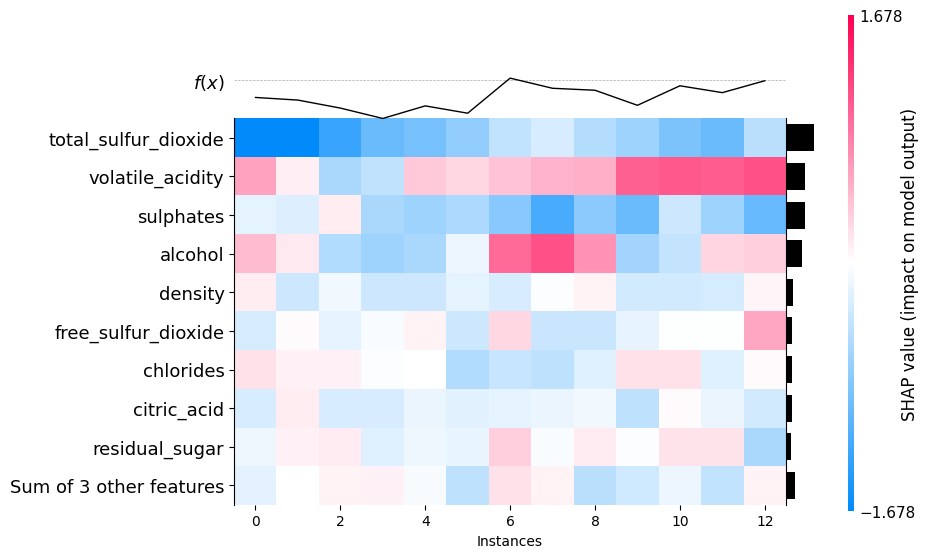

<Axes: xlabel='Instances'>

In [83]:
shap.plots.heatmap(shap_values)

We can see in the heatmap that a high concentration of alcohol combined with a lower value than alcohol but in any case high on volatile acidity and a total sulfur dioxide with a value almost zero leads to have a better wine. We can see the importance of alcohol and to have a low acidity volatile even in the partial dependecies. The higher the value, the better the wine.
We can also see that a good wine may contain little alcohol but to be good it must contain a much higher volatile acidity 
We can see that even the density tends to influence the quality of the wine, although it is less important because we can see in the last heatmap that represents bad wines that its shape values are almost always negative or very low. We see instead that the best wines have a higher density

# Wrap-up and conclusion

As wrap-up, explain what are your key findings, and make 3 recommendations to the wine maker on how to improve the wines for next year. How confident are you that making these changes will lead to better wines? Explain in simple terms to the winemaker the limitations of your approach in terms of capturing causality.

Recomandations: 
1) Balancing the alcohol level with the acid level
2) try to keep the acidity level low
3) check total sulphur levels of sulphur dioxide 


Limitations of the Analysis:
The analysis does not establish causality. While certain features correlate with wine quality, this does not mean that changes in these features will definitively result in improved wine. Other external factors, such as climate, grape variety, and winemaking techniques, also play significant roles in determining wine quality.
